In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
#Import dataset
aviation = pd.read_csv("AviationData.csv", parse_dates=["Event.Date"], encoding = "ISO-8859-1")

In [3]:
aviation.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.Flight,Air.Carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Report.Status,Publication.Date
0,20200102X82407,Accident,WPR20CA055,2019-12-31,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,...,Personal,NaN,NaN,NaN,NaN,1.0,VMC,TAKEOFF,Factual,13/1/2020
1,20191231X83852,Accident,CEN20FA049,2019-12-31,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,...,Personal,NaN,2.0,NaN,NaN,NaN,VMC,TAKEOFF,Preliminary,8/1/2020
2,20200102X54844,Accident,ANC20CA011,2019-12-31,"Fairbanks, AK",United States,64.666945,-148.133334,NaN,NaN,...,Personal,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Preliminary,2/1/2020
3,20191230X91852,Accident,CEN20CA048,2019-12-30,"GRANBURY, TX",United States,32.365556,-97.645000,NaN,NaN,...,Personal,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Preliminary,31/12/2019
4,20191228X62945,NaN,WPR20CA053,2019-12-28,"Missoula, MT",United States,NaN,NaN,MSO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Preliminary,3/1/2020


### Cleaning the data
- Drop the columns we are not using
- Change column names to remove the . in the names for easier coding (some code doesn't work because of the .)
- Delete rows with blanks or unknowns
- Clean any other columns that need specific cleaning


In [4]:
# We are only interested in the Accidents under InvestigationType
accidents = aviation[aviation["Investigation.Type"]=="Accident"].copy()

# Drop columns that are not needed
accidents.drop(["Event.Id", "Accident.Number", "Airport.Code", "Airport.Name","Registration.Number",
               "Model", "FAR.Description", "Schedule", "Purpose.of.Flight", "Air.Carrier", "Report.Status",
               "Publication.Date", "Aircraft.Damage", "Latitude", "Longitude"], axis=1, inplace=True)

In [5]:
# Rename all columns to remove the fullstop .
accidents.rename(columns={"Investigation.Type": "InvestigationType", "Injury.Severity": "InjurySeverity", "Event.Date": "EventDate", "Aircraft.Category": "AircraftCategory", "Amateur.Built": "AmateurBuilt",
                         "Number.of.Engines": "NumberOfEngines", "Engine.Type": "EngineType", "Total.Fatal.Injuries": "TotalFatalInjuries",
                         "Total.Serious.Injuries": "TotalSeriousInjuries", "Total.Minor.Injuries": "TotalMinorInjuries",
                         "Total.Uninjured": "TotalUninjured", "Weather.Condition": "WeatherCondition",
                          "Broad.Phase.of.Flight": "BroadPhaseOfFlight"}, inplace=True)

In [6]:
# Finding out the proportion of Non-USA vs USA accidents

nonusa = accidents[accidents['Country']!="United States"].copy()
usa = accidents[accidents['Country']=="United States"].copy()
print("Non-USA:",nonusa.shape)
print("USA:",usa.shape)

Non-USA: (4328, 16)
USA: (76486, 16)


In [7]:
# Take only accidents within United States
accidents = accidents[accidents['Country']=="United States"]

# Clean predictor variables columns except AircraftCategory because that has too many empty rows
# so we will clean AircraftCategory separately when we analyse it later on
accidents = accidents[accidents["Location"].notnull()]
accidents = accidents[accidents["Make"].notnull()]
accidents["Make"] = accidents["Make"].str.title()
accidents = accidents[accidents["AmateurBuilt"].notnull()]
accidents = accidents[accidents["NumberOfEngines"].notnull()]
accidents = accidents[accidents["EngineType"].notnull()]
accidents = accidents.loc[(accidents["EngineType"] != "None") & (accidents["EngineType"] != "Unknown")]
accidents = accidents[accidents["WeatherCondition"].notnull()]
accidents = accidents[accidents["WeatherCondition"] != "UNK"]
accidents = accidents[accidents["BroadPhaseOfFlight"].notnull()]
accidents = accidents[accidents["BroadPhaseOfFlight"] != "UNKNOWN"]

# Clean response variable InjurySeverity column
accidents = accidents[accidents["InjurySeverity"].notnull()]
accidents = accidents[accidents["InjurySeverity"] != "Unavailable"]
# Change Fatal(1), Fatal(2), Fatal(3), etc. to just Fatal for InjurySeverity column
accidents.loc[(accidents["InjurySeverity"] != "Non-Fatal"), "InjurySeverity"] = "Fatal"

accidents.shape

(69753, 16)

### Data Analysis
Count plot, line plot of the individual factors

In [8]:
print(accidents.dtypes)

InvestigationType               object
EventDate               datetime64[ns]
Location                        object
Country                         object
InjurySeverity                  object
AircraftCategory                object
Make                            object
AmateurBuilt                    object
NumberOfEngines                float64
EngineType                      object
TotalFatalInjuries             float64
TotalSeriousInjuries           float64
TotalMinorInjuries             float64
TotalUninjured                 float64
WeatherCondition                object
BroadPhaseOfFlight              object
dtype: object


#### Event Date

In [9]:
years = accidents.copy()
years["EventDate"] = pd.DatetimeIndex(accidents["EventDate"]).year
print(years.shape)

(69753, 16)


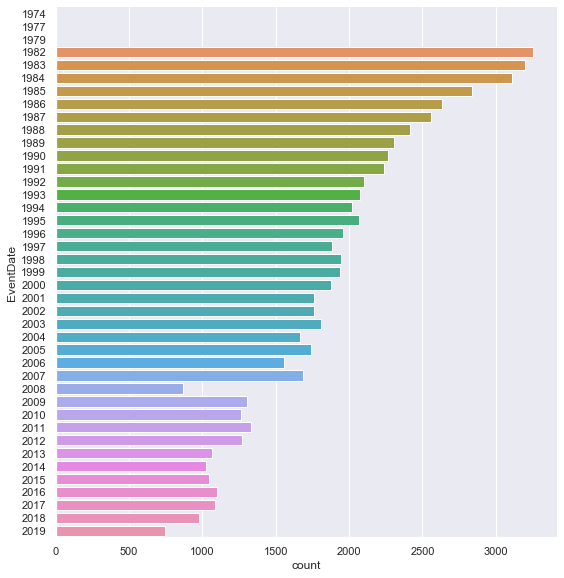

In [10]:
# Count plot to show count of accidents per year
sb.catplot(y = "EventDate", data = years, kind = "count", height = 8)

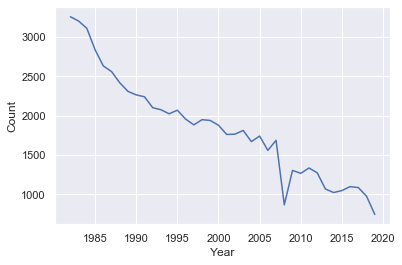

In [11]:
# Plotting line graph to show trend of number of accidents over the years

# Make an array with 2 columns, Years and counts of each year
yrcount = {"Year":years["EventDate"].value_counts().keys().tolist(), "Count":years["EventDate"].value_counts().tolist()}
# Convert array into dataframe
yrcount = pd.DataFrame(yrcount)
# Filter out years that have less than 10 in count
yrcount = yrcount[yrcount["Count"]>11]
sb.lineplot(x="Year", y="Count", data=yrcount)

#### Accidents Grouped by their Quarters (Deeper analysis of EventDate)


Q3    20528
Q2    19598
Q1    14964
Q4    14663
Name: EventDate, dtype: int64


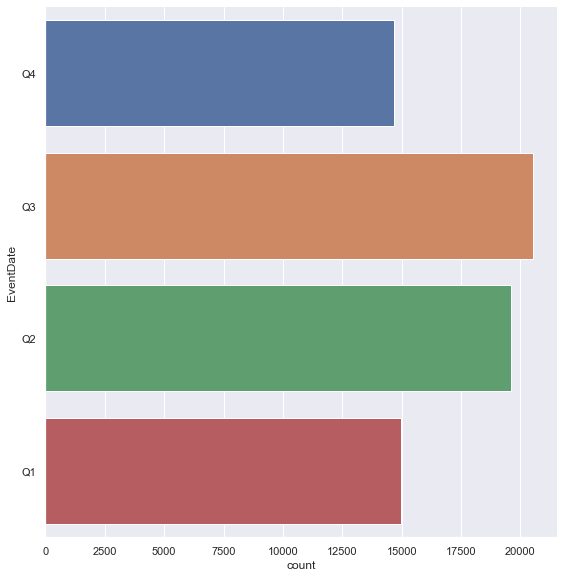

In [12]:
# Group the accidents by the four quarters of the year and see if there's any significant difference in the no. of accidents

quarters = accidents.copy()
quarters["EventDate"] = quarters["EventDate"].dt.month

# Replace each month with their respective quarter under Event.Date column
quarters["EventDate"].replace({1: "Q1", 2: "Q1", 3: "Q1", 4: "Q2", 5: "Q2", 6: "Q2", 7: "Q3", 8: "Q3", 9: "Q3",
                                  10: "Q4", 11: "Q4", 12: "Q4"}, inplace=True)

# Print the number of accidents per quarter and plot the graph
print(quarters["EventDate"].value_counts())
sb.catplot(y = "EventDate", data = quarters, kind = "count", height = 8)

#### Aircraft Category

In [13]:
aircat = pd.DataFrame(accidents["AircraftCategory"])

# Clean AircraftCategory since we did not do it earlier
aircat = accidents[accidents["AircraftCategory"].notnull()]
aircat = aircat[aircat["AircraftCategory"] != "Unknown"]

print("Number of non-blank rows: ", len(aircat["AircraftCategory"]))
print(aircat["AircraftCategory"].value_counts())

Number of non-blank rows:  19826
Airplane             17599
Helicopter            1881
Weight-Shift            83
Gyrocraft               80
Glider                  63
Powered Parachute       49
Gyroplane               44
Ultralight              20
Blimp                    4
Powered-Lift             2
Rocket                   1
Name: AircraftCategory, dtype: int64


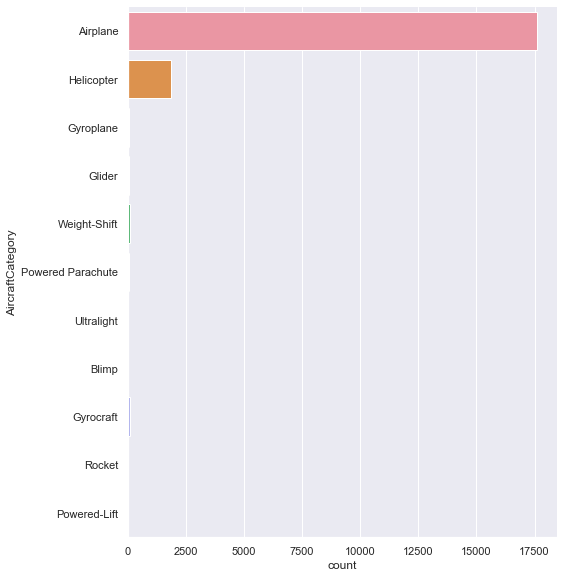

In [14]:
# Count plot for AircraftCategory
sb.catplot(y = "AircraftCategory", data = aircat, kind = "count", height = 8)

#### Make

['Cessna', 'Piper', 'Beech', 'Bell', 'Mooney', 'Grumman', 'Bellanca', 'Robinson', 'Boeing', 'Hughes', 'Air Tractor', 'Aeronca', 'Maule', 'Champion', 'Stinson', 'Luscombe', 'Aero Commander', 'Taylorcraft', 'Schweizer', 'North American']


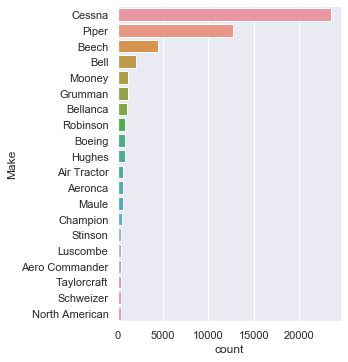

In [15]:
# Get the count of each Make and put the top 20 Makes into a list
makelist = accidents['Make'].value_counts().head(20).index.tolist().copy()
print(makelist)

# Filter top Makes from makelist in dataframe
maketop = accidents[accidents.Make.isin(makelist)]

# Count plot for the top 20 Makes
sb.catplot(y = 'Make', data = maketop, kind = "count", height = 5, order = makelist)

#### Amateur Built

No     62656
Yes     7097
Name: AmateurBuilt, dtype: int64


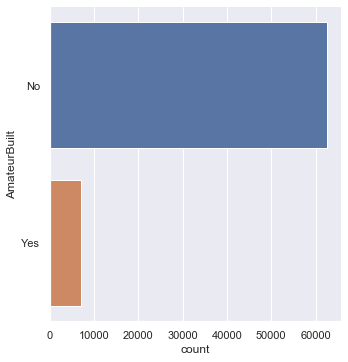

In [16]:
print(accidents["AmateurBuilt"].value_counts())

# Count plot for AmateurBuilt
sb.catplot(y = "AmateurBuilt", data = accidents, kind = "count", height = 5)

#### Number of Engines

1.0    61503
2.0     7922
3.0      165
4.0      162
0.0        1
Name: NumberOfEngines, dtype: int64


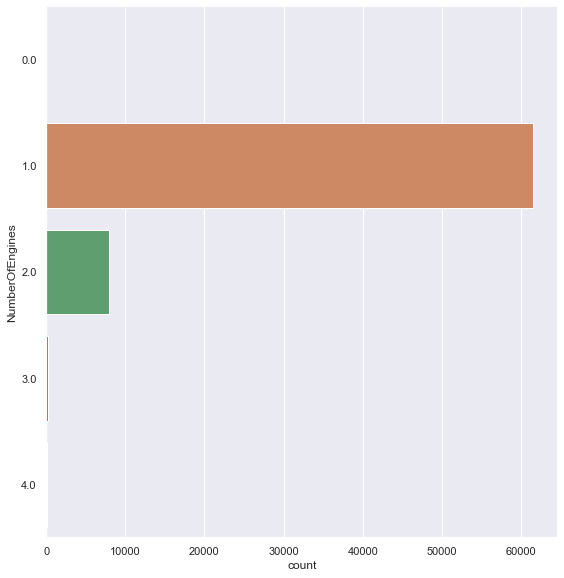

In [17]:
print(accidents["NumberOfEngines"].value_counts())

# Count plot for NumberOfEngines
sb.catplot(y = "NumberOfEngines", data = accidents, kind = "count", height = 8)

#### Engine Type


Reciprocating       62848
Turbo Shaft          2876
Turbo Prop           2547
Turbo Fan            1064
Turbo Jet             410
Electric                3
REC, TJ, TJ             2
REC, ELEC               1
Hybrid Rocket           1
TJ, REC, REC, TJ        1
Name: EngineType, dtype: int64


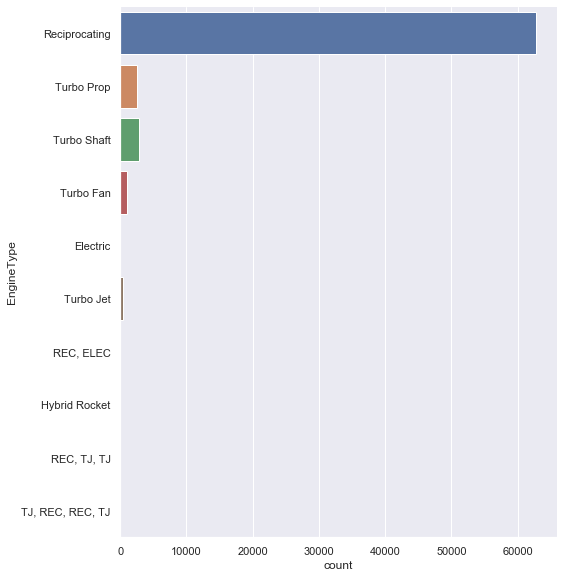

In [18]:
print(accidents["EngineType"].value_counts())

# Count plot for EngineType
sb.catplot(y = "EngineType", data = accidents, kind = "count", height = 8)

#### Weather Condition


VMC    64781
IMC     4972
Name: WeatherCondition, dtype: int64


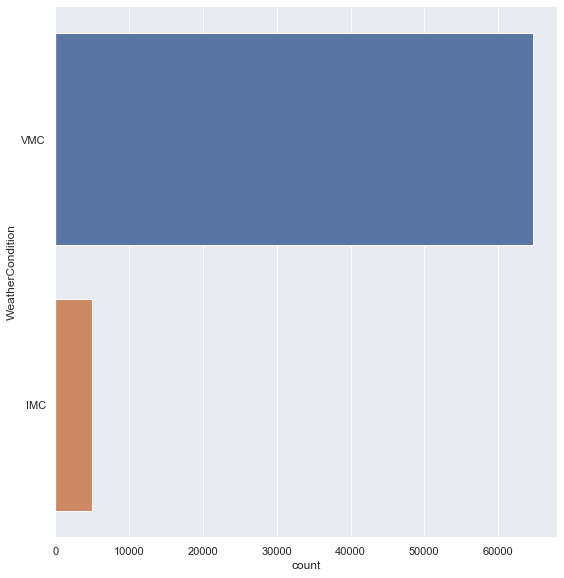

In [19]:
print(accidents["WeatherCondition"].value_counts())

# Count plot for WeatherCondition
sb.catplot(y = "WeatherCondition", data = accidents, kind = "count", height = 8)

#### Broad Phase of Flight



LANDING        18985
TAKEOFF        14933
CRUISE          9899
MANEUVERING     9691
APPROACH        7232
TAXI            2179
CLIMB           2003
DESCENT         1981
GO-AROUND       1626
STANDING        1098
OTHER            126
Name: BroadPhaseOfFlight, dtype: int64


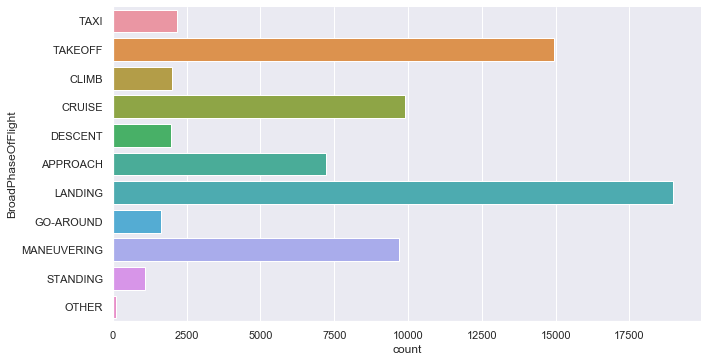

In [20]:
print(accidents["BroadPhaseOfFlight"].value_counts())
flightOrder = ["TAXI","TAKEOFF","CLIMB","CRUISE","DESCENT","APPROACH","LANDING","GO-AROUND","MANEUVERING","STANDING","OTHER"]

# Count plot for Broad Phase of Flight, sorted using flightOrder
sb.catplot(y="BroadPhaseOfFlight", data=accidents, kind="count", aspect=2, order = flightOrder)

#### Injury Severity


Non-Fatal    56988
Fatal        12765
Name: InjurySeverity, dtype: int64


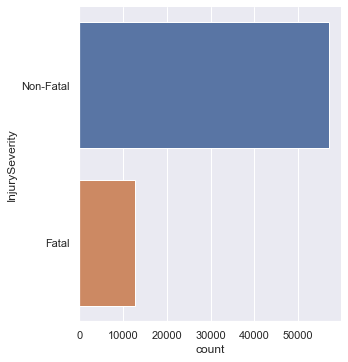

In [114]:
print(accidents["InjurySeverity"].value_counts())

# Count plot for InjurySeverity
sb.catplot(y = "InjurySeverity", data = accidents, kind = "count", height = 5)

#### Fatal Injury Count


In [22]:
# Make an array with 2 columns, TotalFatal and counts of each total
fatalcount = {"TotalFatal":accidents["TotalFatalInjuries"].value_counts().keys().tolist(), "Count":accidents["TotalFatalInjuries"].value_counts().tolist()}
# Convert array into dataframe
fatalcount = pd.DataFrame(fatalcount)
fatalcount = fatalcount[fatalcount["TotalFatal"] != 0]
# Include only TotalFatal with more than 10 in count (more than  10 accidents had that number of TotalFatalInjuries)
fatalcount = fatalcount[fatalcount["Count"]>10]          

   TotalFatal  Count
1         1.0   6613
2         2.0   3804
3         3.0   1115
4         4.0    753
5         5.0    204
6         6.0    117
7         7.0     41
8         8.0     27
9        10.0     19


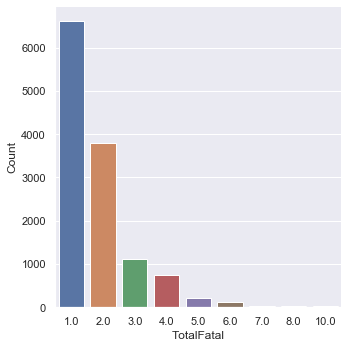

In [23]:
print(fatalcount)

# Count plot for TotalFatalInjuries where more than 10 accidents had that number of TotalFatalInjuries
sb.catplot(x = "TotalFatal", y = "Count", data=fatalcount, kind="bar")

### Pairwise Comparisons
Compare InjurySeverity with each of all the other predictors
- Distribution of accidents in USA using a map of USA
- Classification using Gaussian Naive Bayes


#### Distribution of Accidents in USA


In [24]:
# Install and import geopandas
!pip install geopandas #if this doesn't work for jupyter then use anaconda prompt and input "conda install geopandas"
import geopandas as gpd

ERROR: Invalid requirement: '#if'


In [25]:
fp = r"datasets/USA/states.shp"
map_df = gpd.read_file(fp)
# Check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
5,South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."
6,Wyoming,7,56,Mountain,WY,"POLYGON ((-104.05362 41.69822, -104.05550 41.5..."
7,Wisconsin,8,55,East North Central,WI,"MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ..."
8,Idaho,9,16,Mountain,ID,"POLYGON ((-117.02630 43.67903, -117.02379 43.7..."
9,Vermont,10,50,New England,VT,"POLYGON ((-73.25806 42.74606, -73.26928 42.747..."


In [26]:
# Remove Alaska and Hawaii as they are not within Central America Map
map_df_centre = map_df[(map_df["STATE_NAME"]!="Alaska") & (map_df["STATE_NAME"]!="Hawaii")].copy()
map_df_centre

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
5,South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."
6,Wyoming,7,56,Mountain,WY,"POLYGON ((-104.05362 41.69822, -104.05550 41.5..."
7,Wisconsin,8,55,East North Central,WI,"MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ..."
8,Idaho,9,16,Mountain,ID,"POLYGON ((-117.02630 43.67903, -117.02379 43.7..."
9,Vermont,10,50,New England,VT,"POLYGON ((-73.25806 42.74606, -73.26928 42.747..."
10,Minnesota,11,27,West North Central,MN,"POLYGON ((-91.73037 43.49957, -92.07753 43.499..."


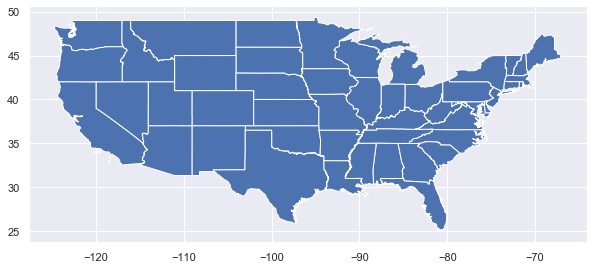

In [27]:
f, axes = plt.subplots(1, 1, figsize=(10,10))
map_df_centre.plot(ax=axes) # if this doesn't work for jupyter then use anaconda prompt and input "conda install descartes"

In [28]:
usa = accidents[["Location","InjurySeverity","TotalFatalInjuries"]]
usa.head()

,Location,InjurySeverity,TotalFatalInjuries
0,"Elk, CA",Non-Fatal,NaN
1,"OLATHE, KS",Fatal,2.0
5,"LAFAYETTE, LA",Fatal,5.0
6,"Headland, AL",Fatal,1.0
14,"Harrison, OH",Non-Fatal,NaN


In [29]:
# Get the abbreviation of each State for merging with GeoDataFrame by States
# Warning, will take a while to run
states = usa[usa["Location"].notnull()].copy()

for index, row in states.iterrows():
     states.loc[index,"Location"] = row["Location"].split(', ')[-1:]

In [30]:
stateslist = map_df_centre["STATE_ABBR"].value_counts().keys().tolist()
statesclean = states[states.Location.isin(stateslist)]

In [31]:
# Get Accident Count of each State
accidentcount = {"State":statesclean["Location"].value_counts().keys().tolist(), "AccidentCount":statesclean["Location"].value_counts().tolist()}
# Convert array into dataframe
accidentcount = pd.DataFrame(accidentcount)
accidentcount

,State,AccidentCount
0,CA,7612
1,TX,4936
2,FL,4848
3,AZ,2355
4,WA,2228
5,CO,2224
6,MI,1762
7,GA,1677
8,IL,1638
9,NY,1571


In [32]:
# Get the Fatal and Non-Fatal Counts of each State
statefatalcount = statesclean[statesclean["InjurySeverity"]=="Fatal"].copy()
statefatalcount = {"State":statefatalcount["Location"].value_counts().keys().tolist(), "FatalCount":statefatalcount["Location"].value_counts().tolist()}
statefatalcount = pd.DataFrame(statefatalcount)
print(statefatalcount.head())

statenonfatalcount = statesclean[statesclean["InjurySeverity"]=="Non-Fatal"].copy()
statenonfatalcount = {"State":statenonfatalcount["Location"].value_counts().keys().tolist(), "NonFatalCount":statenonfatalcount["Location"].value_counts().tolist()}
statenonfatalcount = pd.DataFrame(statenonfatalcount)
print(statenonfatalcount.head())

  State  FatalCount
0    CA        1642
1    FL         887
2    TX         860
3    CO         419
4    AZ         403
  State  NonFatalCount
0    CA           5970
1    TX           4076
2    FL           3961
3    AZ           1952
4    WA           1855


In [33]:
# Merge State Accident Count with States GEODataFrame
merged = map_df_centre.set_index("STATE_ABBR").join(accidentcount.head(49).set_index("State"))
merged = merged.join(statefatalcount.set_index("State"))
merged = merged.join(statenonfatalcount.set_index("State"))
merged

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,geometry,AccidentCount,FatalCount,NonFatalCount
STATE_ABBR,,,,,,,,
WA,Washington,2,53,Pacific,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",2228,373,1855
MT,Montana,3,30,Mountain,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",914,156,758
ME,Maine,4,23,New England,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",439,78,361
ND,North Dakota,5,38,West North Central,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",505,49,456
SD,South Dakota,6,46,West North Central,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",386,84,302
WY,Wyoming,7,56,Mountain,"POLYGON ((-104.05362 41.69822, -104.05550 41.5...",641,121,520
WI,Wisconsin,8,55,East North Central,"MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ...",1353,237,1116
ID,Idaho,9,16,Mountain,"POLYGON ((-117.02630 43.67903, -117.02379 43.7...",1200,209,991
VT,Vermont,10,50,New England,"POLYGON ((-73.25806 42.74606, -73.26928 42.747...",197,45,152


In [38]:
# Set a variable that will call whatever column we want to visualise on the map
def display_map(x):
    # Set the range for the choropleth
    vmin, vmax = 120, 220

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(10, 6))

    # Create map
    merged.plot(column=x, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

    # Now we can customise and add annotations

    # Remove the axis
    ax.axis("off")
    title = x + " in USA"
    # Add a title
    ax.set_title(title, \
                  fontdict={"fontsize": "25",
                            "fontweight" : "3"})

    # create an annotation for the  data source
    #ax.annotate('Source: London Datastore, 2014',
    #           xy=(0.1, .08), xycoords='figure fraction',
    #           horizontalalignment='left', verticalalignment='top',
    #           fontsize=10, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)

    # This will save the figure as a high-resolution png. you can also save as svg
    #fig.savefig('testmap.png', dpi=300)


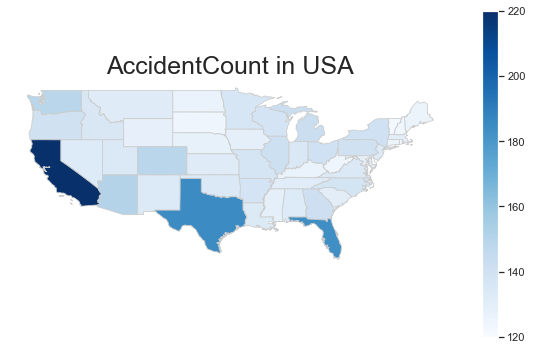

In [39]:
display_map("AccidentCount")

#### Classification using Gaussian Naive Bayes

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [44]:
def gau_nb(X):
    
    # This function cannot run if the columns have blanks 
    accidentsc=accidents[accidents[X].notnull()]
    
    # Split train and test data 
    train_data,test_data = train_test_split(accidentsc,test_size=0.20)
    train_x = train_data[X]
    train_y = train_data["InjurySeverity"]

    test_x = test_data[X]
    test_y = test_data["InjurySeverity"]

    # Transform x & y into one-hot encoder
    enc = preprocessing.LabelEncoder()
    enc_train_x = enc.fit_transform(train_x).reshape(-1,1)
    enc_train_y = enc.fit_transform(train_y)

    enc_test_x=enc.fit_transform(test_x).reshape(-1,1)
    enc_test_y=enc.fit_transform(test_y)

    # Gaussian Naive Bayes
    model = GaussianNB(var_smoothing=0.01)

    # Fit the model with the training data
    model.fit(enc_train_x,enc_train_y)

    # Predict InjurySeverity using train dataset
    predict_train = model.predict(enc_train_x)
    print("Predicted InjurySeverity using train data:", predict_train) 

    # Accuracy Score of train dataset
    accuracy_train = accuracy_score(enc_train_y,predict_train)
    print("Accuracy score of train dataset:", accuracy_train)

    # Predict InjurySeverity using test dataset
    predict_test = model.predict(enc_test_x)
    print("Predicted InjurySeverity using test data:", predict_test) 

    # Accuracy Score of test dataset
    accuracy_test = accuracy_score(enc_test_y,predict_test)
    print("Accuracy score of test dataset:", accuracy_test)

In [45]:
varList=["Location","AircraftCategory","Make","AmateurBuilt","NumberOfEngines","EngineType","WeatherCondition","BroadPhaseOfFlight"]

# Naive Bayes using each predictor (individually)
for var in varList:
  print("Using", var, "as predictor:")
  gau_nb(var)
  print()

# Take note that for AircraftCategory, the data used is different from other predictors as AircraftCategory was left out during the general cleaning of data
# so for this naive bayes classification using AircraftCategory, the data set has only about 18,000+ rows while the data sets using the other predictors below
# has about 44,000+ rows

Using Location as predictor:
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8168703630694241
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8175041215683464

Using AircraftCategory as predictor:
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8519008889729526
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8408976298537569

Using Make as predictor:
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8172108526576108
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8161422120278117

Using AmateurBuilt as predictor:
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.7682699544819183
Predicted InjurySeverity using test data: [1 1 1 ... 1 0 1]
Accuracy score of test datas

### More In-Depth Classifcation using Gaussian Naive Bayes
- Use Naive Bayes to classify InjurySeverity using different groups of more than 1 predictor


#### Naive Bayes using 2 predictors

In [59]:
def twovar_nb(x1,x2):
  try:
    # This function cannot run if the columns have blanks 
    accidentsc=accidents[accidents[x1].notnull()]
    accidentsc=accidentsc[accidentsc[x2].notnull()]

    # Read the train and test dataset
    train_data,test_data = train_test_split(accidentsc,test_size=0.20)

    print("Variables:", x1, "and", x2)

    # Shape of the dataset
    print("Shape of training data:", train_data.shape)
    print("Shape of testing data:", test_data.shape)

    # Seperate the predictors and response variable of train data
    train_x1_pair = train_data[x1]
    train_x2_pair = train_data[x2]
    train_y_pair = train_data["InjurySeverity"]

    # Seperate the predictors and response variable of test data
    test_x1_pair = test_data[x1]
    test_x2_pair = test_data[x2]
    test_y_pair = test_data["InjurySeverity"]

    enc = preprocessing.LabelEncoder()
    enc_train_x1_pair = enc.fit_transform(train_x1_pair)
    enc_train_x2_pair = enc.fit_transform(train_x2_pair)
    enc_train_y_pair = enc.fit_transform(train_y_pair)

    # Change the arguments in zip() to add/remove var
    features_pair = list(zip(enc_train_x1_pair,enc_train_x2_pair))

    model_pair = GaussianNB(var_smoothing=0.00000001)

    # Fit the model with train data
    model_pair.fit(features_pair,enc_train_y_pair)

    # Predict InjurySeverity using train dataset
    predict_train_pair = model_pair.predict(features_pair)
    print("Predicted InjurySeverity using train data:", predict_train_pair) 

    # Accuracy Score of train dataset
    accuracy_train_pair = accuracy_score(enc_train_y_pair,predict_train_pair)
    print("Accuracy score of train dataset:", accuracy_train_pair)

    # Predict InjurySeverity using test dataset
    predict_test_pair = model_pair.predict(list(zip(enc.fit_transform(test_x1_pair),enc.fit_transform(test_x2_pair))))
    print("Predicted InjurySeverity using test data:", predict_test_pair) 

    # Accuracy Score of test dataset
    accuracy_test_pair = accuracy_score(enc.fit_transform(test_y_pair),predict_test_pair)
    print("Accuracy score of test dataset:", accuracy_test_pair)
    print()
    return accuracy_train_pair
  except ZeroDivisionError:
    print("Error occured when running", x1, "and", x2)
    print()
    return

In [89]:
import itertools
# Create Dictionary of variables
varDict = {}
for i in varList:
    varDict[i] = 0
# Generate accuracy score of all pairs
for pair in itertools.combinations(varList,r=2):
    score = twovar_nb(*pair)
    # Add up scores for each variable
    for i in varDict:
        if pair[0] == i:
            varDict[i] += score
        if pair[1] == i:
            varDict[i] += score
# Get average accuracy score for each variable
for i in varDict:
    varDict[i] /= len(varDict)-1

Variables: Location and AircraftCategory
Shape of training data: (15861, 16)
Shape of testing data: (3966, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8512704117016582
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8434190620272315

Variables: Location and Make
Shape of training data: (55802, 16)
Shape of testing data: (13951, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8183040034407368
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8117697656082001

Variables: Location and AmateurBuilt
Shape of training data: (55802, 16)
Shape of testing data: (13951, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8169241245833483
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8172890832198408

Variab

Predicted InjurySeverity using train data: [1 1 1 ... 1 1 0]
Accuracy score of train dataset: 0.8283215655352855
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8356390222923088

Variables: EngineType and BroadPhaseOfFlight
Shape of training data: (55802, 16)
Shape of testing data: (13951, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.7979104691588115
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8177908393663537

Variables: WeatherCondition and BroadPhaseOfFlight
Shape of training data: (55802, 16)
Shape of testing data: (13951, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8286262141141895
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 0]
Accuracy score of test dataset: 0.8344204716507777



In [90]:
# Display average accuracy score for each variable
print("Average Accuracy Scores")
for i in varDict:
    print(i,": ", varDict[i])

Average Accuracy Scores
Location :  0.8218972989032035
AircraftCategory :  0.8395615480919056
Make :  0.8185099737576002
AmateurBuilt :  0.8015002732323735
NumberOfEngines :  0.8052124313522705
EngineType :  0.8048805844486697
WeatherCondition :  0.8311995785339804
BroadPhaseOfFlight :  0.8126440807838768


#### Naive Bayes using all 8 predictors

In [100]:
accidentsc=accidents.copy()
for i in varList:
  accidentsc=accidentsc[accidentsc[i].notnull()]

# Split the data to get train and test datasets
train_data,test_data = train_test_split(accidentsc,test_size=0.20)

# Print shape of the datasets
print("Shape of train data:", train_data.shape)
print("Shape of test data:", test_data.shape)

# Seperate the predictors and response variable of train data
train_x1_all = train_data["AircraftCategory"]
train_x2_all = train_data["Make"]
train_x3_all = train_data["AmateurBuilt"]
train_x4_all = train_data["NumberOfEngines"]
train_x5_all = train_data["EngineType"]
train_x6_all = train_data["WeatherCondition"]
train_x7_all = train_data["BroadPhaseOfFlight"]
train_x8_all = train_data["Location"]
train_y_all = train_data["InjurySeverity"]

# Seperate the predictors and response variable of test data
test_x1_all = test_data["AircraftCategory"]
test_x2_all = test_data["Make"]
test_x3_all = test_data["AmateurBuilt"]
test_x4_all = test_data["NumberOfEngines"]
test_x5_all = test_data["EngineType"]
test_x6_all = test_data["WeatherCondition"]
test_x7_all = test_data["BroadPhaseOfFlight"]
test_x8_all = test_data["Location"]
test_y_all = test_data["InjurySeverity"]

enc = preprocessing.LabelEncoder()
enc_train_x1_all = enc.fit_transform(train_x1_all)
enc_train_x2_all = enc.fit_transform(train_x2_all)
enc_train_x3_all = enc.fit_transform(train_x3_all)
enc_train_x4_all = enc.fit_transform(train_x4_all)
enc_train_x5_all = enc.fit_transform(train_x5_all)
enc_train_x6_all = enc.fit_transform(train_x6_all)
enc_train_x7_all = enc.fit_transform(train_x7_all)
enc_train_x8_all = enc.fit_transform(train_x8_all)
enc_train_y_all = enc.fit_transform(train_y_all)

features_all = list(zip(enc_train_x1_all,enc_train_x2_all,enc_train_x3_all,enc_train_x4_all,enc_train_x5_all,enc_train_x6_all,enc_train_x7_all,enc_train_x8_all))

model_all = GaussianNB(var_smoothing=0.00000001)

# Fit the model with the train data
model_all.fit(features_all,enc_train_y_all)

# Predict InjurySeverity using train dataset
predict_train_all = model_all.predict(features_all)
print("Predicted InjurySeverity using train data:", predict_train_all) 

# Accuracy Score of train dataset
accuracy_train_all = accuracy_score(enc_train_y_all,predict_train_all)
print("Accuracy score of train dataset:", accuracy_train_all)

# Predict InjurySeverity using test dataset
predict_test_all = model_all.predict(list(zip(enc.fit_transform(test_x1_all),enc.fit_transform(test_x2_all),enc.fit_transform(test_x3_all),enc.fit_transform(test_x4_all),
                                              enc.fit_transform(test_x5_all),enc.fit_transform(test_x6_all),enc.fit_transform(test_x7_all),enc.fit_transform(test_x8_all))))
print("Predicted InjurySeverity using test data:", predict_test_all)

# Accuracy Score of test dataset
enc_test_y_all = enc.fit_transform(test_y_all)
accuracy_test_all = accuracy_score(enc_test_y_all,predict_test_all)
print("Accuracy score of test dataset:", accuracy_test_all)

Shape of train data: (15861, 16)
Shape of test data: (3966, 16)
Predicted InjurySeverity using train data: [1 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8472353571653742
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8121533030761473


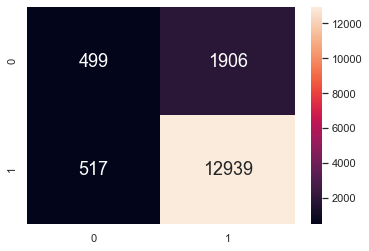

In [112]:
# Confusion matrix of train data (with 8 predictors)
sb.heatmap(confusion_matrix(enc_train_y_all, predict_train_all),
           annot = True, fmt=".0f", annot_kws={"size": 18})

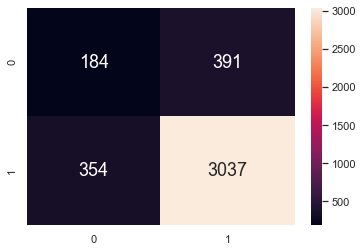

In [113]:
# Confusion matrix of test data (with 8 predictors)
sb.heatmap(confusion_matrix(enc_test_y_all, predict_test_all),
           annot = True, fmt=".0f", annot_kws={"size": 18})

#### Naive Bayes using 6 predictors (AircraftCategory, Location, Make, AmateurBuilt, WeatherCondition, BroadPhaseOfFlight)
These predictors were chosen based on the accuracy scores of their individual naive bayes and pair naive bayes.
<br>This model is found to be the best model so far for classifying InjurySeverity

In [109]:
varList2 = ["AircraftCategory","Location","Make","AmateurBuilt","WeatherCondition","BroadPhaseOfFlight"]

accidentsc=accidents.copy()
for i in varList2:
  accidentsc=accidentsc[accidentsc[i].notnull()]

# Split the data to get train and test datasets
train_data,test_data = train_test_split(accidentsc,test_size=0.20)

# Print shape of the datasets
print("Shape of train data:", train_data.shape)
print("Shape of test data:", test_data.shape)

# Seperate the predictors and response variable of train data
train_x1_best = train_data["AircraftCategory"]
train_x2_best = train_data["Make"]
train_x3_best = train_data["AmateurBuilt"]
train_x4_best = train_data["WeatherCondition"]
train_x5_best = train_data["BroadPhaseOfFlight"]
train_x6_best = train_data["Location"]
train_y_best = train_data["InjurySeverity"]

# Seperate the predictors and response variable of test data
test_x1_best = test_data["AircraftCategory"]
test_x2_best = test_data["Make"]
test_x3_best = test_data["AmateurBuilt"]
test_x4_best = test_data["WeatherCondition"]
test_x5_best = test_data["BroadPhaseOfFlight"]
test_x6_best = test_data["Location"]
test_y_best = test_data["InjurySeverity"]

enc = preprocessing.LabelEncoder()
enc_train_x1_best = enc.fit_transform(train_x1_best)
enc_train_x2_best = enc.fit_transform(train_x2_best)
enc_train_x3_best = enc.fit_transform(train_x3_best)
enc_train_x4_best = enc.fit_transform(train_x4_best)
enc_train_x5_best = enc.fit_transform(train_x5_best)
enc_train_x6_best = enc.fit_transform(train_x6_best)
enc_train_y_best = enc.fit_transform(train_y_best)


features_best = list(zip(enc_train_x1_best,enc_train_x2_best,enc_train_x3_best,enc_train_x4_best,enc_train_x5_best,enc_train_x6_best))

model_best = GaussianNB(var_smoothing=0.00000001)

# Fit the model with the training data
model_best.fit(features_best,enc_train_y_best)

# Predict InjurySeverity using train dataset
predict_train_best = model_best.predict(features_best)
print("Predicted InjurySeverity using train data:", predict_train_best) 

# Accuray Score of train dataset
accuracy_train_best = accuracy_score(enc_train_y_best,predict_train_best)
print("Accuracy score of train dataset:", accuracy_train_best)

# Predict InjurySeverity using test dataset
predict_test_best = model_best.predict(list(zip(enc.fit_transform(test_x1_best),enc.fit_transform(test_x2_best),enc.fit_transform(test_x3_best),
                                                enc.fit_transform(test_x4_best),enc.fit_transform(test_x5_best),enc.fit_transform(test_x6_best))))
print("Predicted InjurySeverity using test data:", predict_test_best)

# Accuracy Score of test dataset
enc_test_y_best = enc.fit_transform(test_y_best)
accuracy_test_best = accuracy_score(enc_test_y_best,predict_test_best)
print("Accuracy score of test dataset:", accuracy_test_best)

Shape of train data: (15861, 16)
Shape of test data: (3966, 16)
Predicted InjurySeverity using train data: [0 1 1 ... 1 1 1]
Accuracy score of train dataset: 0.8519008889729526
Predicted InjurySeverity using test data: [1 1 1 ... 1 1 1]
Accuracy score of test dataset: 0.8686333837619769


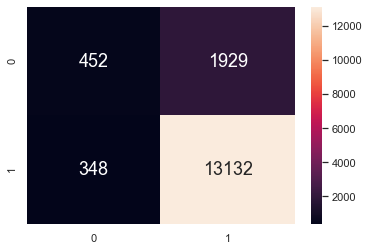

In [50]:
# Confusion matrix of train data for the best model (with 6 predictors)
sb.heatmap(confusion_matrix(enc_train_y_best, predict_train_best),
           annot = True, fmt=".0f", annot_kws={"size": 18})

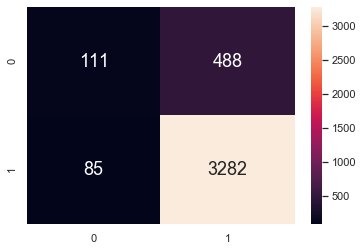

In [51]:
# Confusion matrix of test data for the best model (with 6 predictors)
sb.heatmap(confusion_matrix(enc_test_y_best, predict_test_best),
           annot = True, fmt=".0f", annot_kws={"size": 18})